In [1]:
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#import tensorflow
import soundfile as sf
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft, fftfreq
import librosa
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import os
import pandas as pd

## Daten einlesen
siehe librosa_files

In [2]:
# determine path to `src/data`
cwd = os.getcwd()
src_dir = os.path.join(cwd, os.pardir)
data_dir = os.path.join(src_dir, 'data')

# get absolute paths for each file in `src/data`
data_file_paths = map(
    lambda file: os.path.join(data_dir, file),
    os.listdir(data_dir)
)
data_file_paths = list(data_file_paths)

In [3]:
feature_matrix = []
labels = []

max_iter = 10

for file in data_file_paths[:max_iter]:
    base = os.path.splitext(file)[0]
    extension = os.path.splitext(file)[1]
    
    if extension == '.flac' and os.path.isfile(base + '.csv'):
        label_file = pd.read_csv(base + '.csv')
        for index, row in label_file.iterrows():
            start = row['start']
            if start < 0: start = 0
            end = row['end']
            duration = end - start
            
            if duration <= 0:
                print(file)
                print(f'In row {index}')
                continue
            
            waveform, sample_rate = librosa.load(
                file,
                sr=None,    # do not resample file
                mono=True,
                offset=start,
                duration=duration)
            
            feature_matrix.append([fft(waveform), fftfreq(waveform.size, 1/sample_rate)])
            labels.append(-1 if (row['label'] == 'No_Whistle') else 1)

/home/johann/Dokumente/Studium/Master/2.Semester/Mustererkennung/24-mus-whistle/src/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/johann/Dokumente/Studium/Master/2.Semester/Mustererkennung/24-mus-whistle/src/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


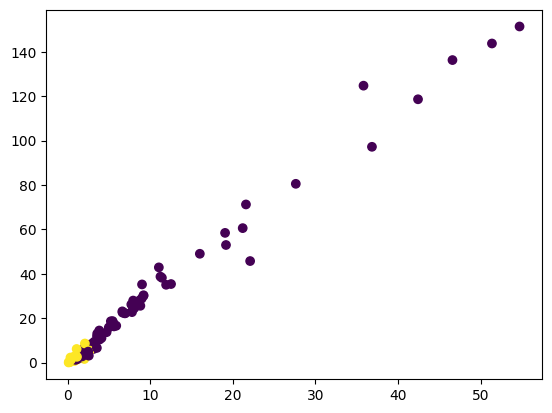

In [4]:
xs = []
for feature in feature_matrix:
    xs.append([np.average(np.abs(feature[0][x])) for x in np.where((feature[1] >= 20) & (feature[1] <= 30))])

ys = []
for feature in feature_matrix:
    ys.append([np.average(np.abs(feature[0][x])) for x in np.where((feature[1] >= 30) & (feature[1] <= 40))])
    
plt.scatter(xs,ys,c=labels)
plt.show()